Lets do some heatmaps

In [1]:
from scipy.ndimage.filters import gaussian_filter
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import pyxdf

C:\Users\Bolo\AppData\Local\Temp\ipykernel_21700\3018520907.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)



002/
    annotation.pldata
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps.npy
  

In [3]:
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'surfaces','gaze_positions_on_surface_Surface_1.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)



In [4]:
gaze_pd_frame.columns

Index(['world_timestamp', 'world_index', 'gaze_timestamp', 'x_norm', 'y_norm',
       'x_scaled', 'y_scaled', 'on_surf', 'confidence'],
      dtype='object')

In [4]:
image_location="../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"
print_file_structure(image_location)


002/
    annotation.pldata
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps.npy
  

In [6]:
image=plt.imread(image_location+'/Surprise01_42.tif')
image.shape

(1440, 2560, 3)

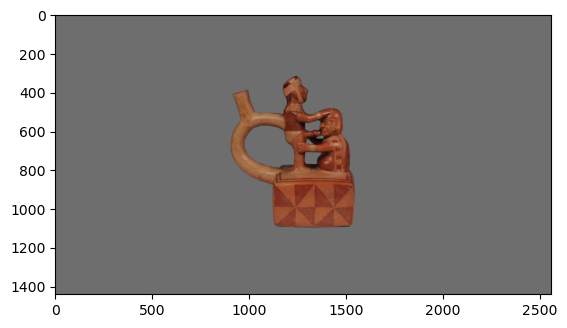

In [7]:
fig,ax=plt.subplots(1,1)
ax.imshow(image[:,:,:])


In [8]:

conf_thr=0.95
gaze_on_surf=gaze_pd_frame[(gaze_pd_frame.on_surf==True)&(gaze_pd_frame.confidence >conf_thr)]
pd.options.display.float_format = None

gaze_on_surf.head(5)


,world_timestamp,world_index,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence
126,14963.965010,26,14963.972059,0.235153,0.028235,0.235153,0.028235,True,0.995
127,14963.985129,27,14963.976082,0.231901,0.055803,0.231901,0.055803,True,0.995
128,14963.985129,27,14963.980072,0.224674,0.135685,0.224674,0.135685,True,0.995
129,14963.985129,27,14963.984049,0.211314,0.187131,0.211314,0.187131,True,0.990
130,14963.985129,27,14963.988105,0.202950,0.256136,0.202950,0.256136,True,0.990


Now filter desired image

In [9]:
index_stim=annotations_pd['label']=='Surprise01.tif'
index_final=annotations_pd.index[index_stim]+1
index_final


Int64Index([126], dtype='int64')

In [10]:
interval=0.1
value=annotations_pd[index_stim]['timestamp'].values[0]
value_final=annotations_pd.iloc[index_final]['timestamp'].values[0]
 
gaze_on_surf=gaze_on_surf[
    (gaze_on_surf['gaze_timestamp']>value)&
    (gaze_on_surf['gaze_timestamp']<value_final)

]



In [11]:
(gaze_on_surf['gaze_timestamp']>value)

123329    True
123330    True
123331    True
123332    True
123333    True
          ... 
124819    True
124820    True
124821    True
124822    True
124823    True
Name: gaze_timestamp, Length: 1495, dtype: bool

In [38]:
15258.6367544

15258.6367544

In [12]:
type(gaze_pd_frame.on_surf)

pandas.core.series.Series

Cover image with heatmap overlay


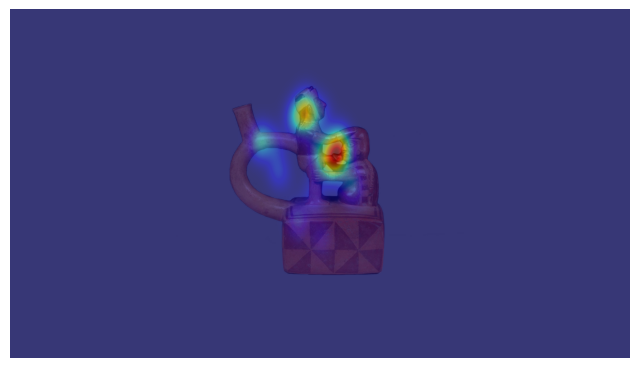

In [13]:
%matplotlib inline

grid = image.shape[0:2] # height, width of the loaded image
heatmap_detail = 0.02 # this will determine the gaussian blur kerner of the image (higher number = more blur)

gaze_on_surf_x = gaze_on_surf['x_norm']
gaze_on_surf_y = gaze_on_surf['y_norm']

# flip the fixation points
# from the original coordinate system,
# where the origin is at botton left,
# to the image coordinate system,
# where the origin is at top left
gaze_on_surf_y = 1 - gaze_on_surf_y

# make the histogram
hist, x_edges, y_edges = np.histogram2d(
    gaze_on_surf_y,
    gaze_on_surf_x,
    range=[[0, 1.0], [0, 1.0]],
    bins=grid
)


# gaussian blur kernel as a function of grid/surface size
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
heatmap = gaussian_filter(hist, sigma=(filter_w, filter_h), order=0)

# display the histogram and reference image
print("Cover image with heatmap overlay")
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off');



Lets do it another way

Cover image with heatmap overlay


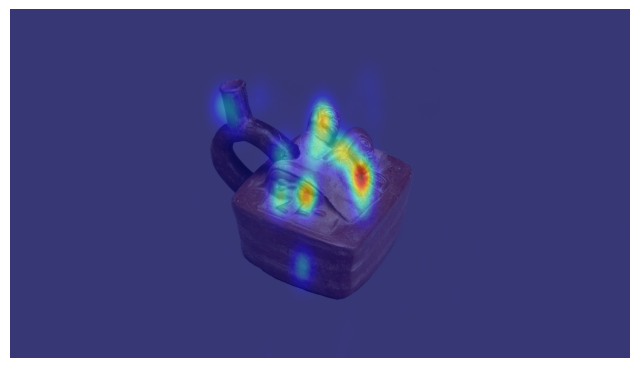

In [68]:
grid = image.shape[0:2] # height, width of the loaded image
heatmap_detail = 0.02 # this will determine the gaussian blur kerner of the image (higher number = more blur)

x = gaze_on_surf['x_norm']
y = gaze_on_surf['y_norm']

# flip the fixation points
# from the original coordinate system,
# where the origin is at botton left,
# to the image coordinate system,
# where the origin is at top left
y = 1 - y

# scale up the normalized coordinates for x and y 
x *= grid[1]
y *= grid[0]



# gaussian blur kernel as a function of grid/surface size
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
heatmap = gaussian_filter(hist, sigma=(filter_w, filter_h), order=0)

# display the histogram and reference image
print("Cover image with heatmap overlay")
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off');

